# Test with real SCADA data

In [1]:
import logging
import os
from pathlib import Path

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import numpy as np

import seaborn as sns

import torch

import xarray as xr


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()


# DEFAULT
DATA_FOLDER = Path(os.getenv('BASE')) / 'data'

## Load data

In [2]:
ds = xr.load_dataset(DATA_FOLDER / 'turb.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (wt: 116, time: 102932)
Coordinates:
  * wt              (wt) <U7 3kB 'WTG-001' 'WTG-002' ... 'WTG-117' 'WTG-118'
  * time            (time) datetime64[ns] 823kB 2022-02-06T06:00:00 ... 2024-...
Data variables: (12/33)
    ws_avg          (wt, time) float64 96MB 3.305 3.569 5.235 ... 7.118 7.014
    ws_corr         (time, wt) float64 96MB 4.149 4.709 4.437 ... 7.053 7.051
    ws_std_corr     (wt, time) float64 96MB 1.1 0.8873 0.9222 ... 0.8457 0.9124
    nac_pos_avg     (wt, time) float64 96MB 225.6 249.0 253.3 ... 188.4 185.2
    yaw_calibrated  (wt, time) float64 96MB 202.8 226.3 230.5 ... 236.8 233.6
    yaw_err_avg     (wt, time) float64 96MB 7.717 -1.323 1.742 ... -2.308 -1.902
    ...              ...
    is_aligned      (wt, time) bool 12MB False True False ... False False False
    yaw_ok          (wt, time) bool 12MB True True True True ... True True True
    is_train        (wt, time) bool 12MB False True False ... False False False
    is_analysis     (wt, time) bool 12MB True True True True ... True True True
    power_aligned   (time, wt) float64 96MB 107.4 nan 85.79 ... 698.8 725.7
    power_ratio     (wt, time) float64 96MB 0.7139 0.5206 ... 0.9996 0.8648

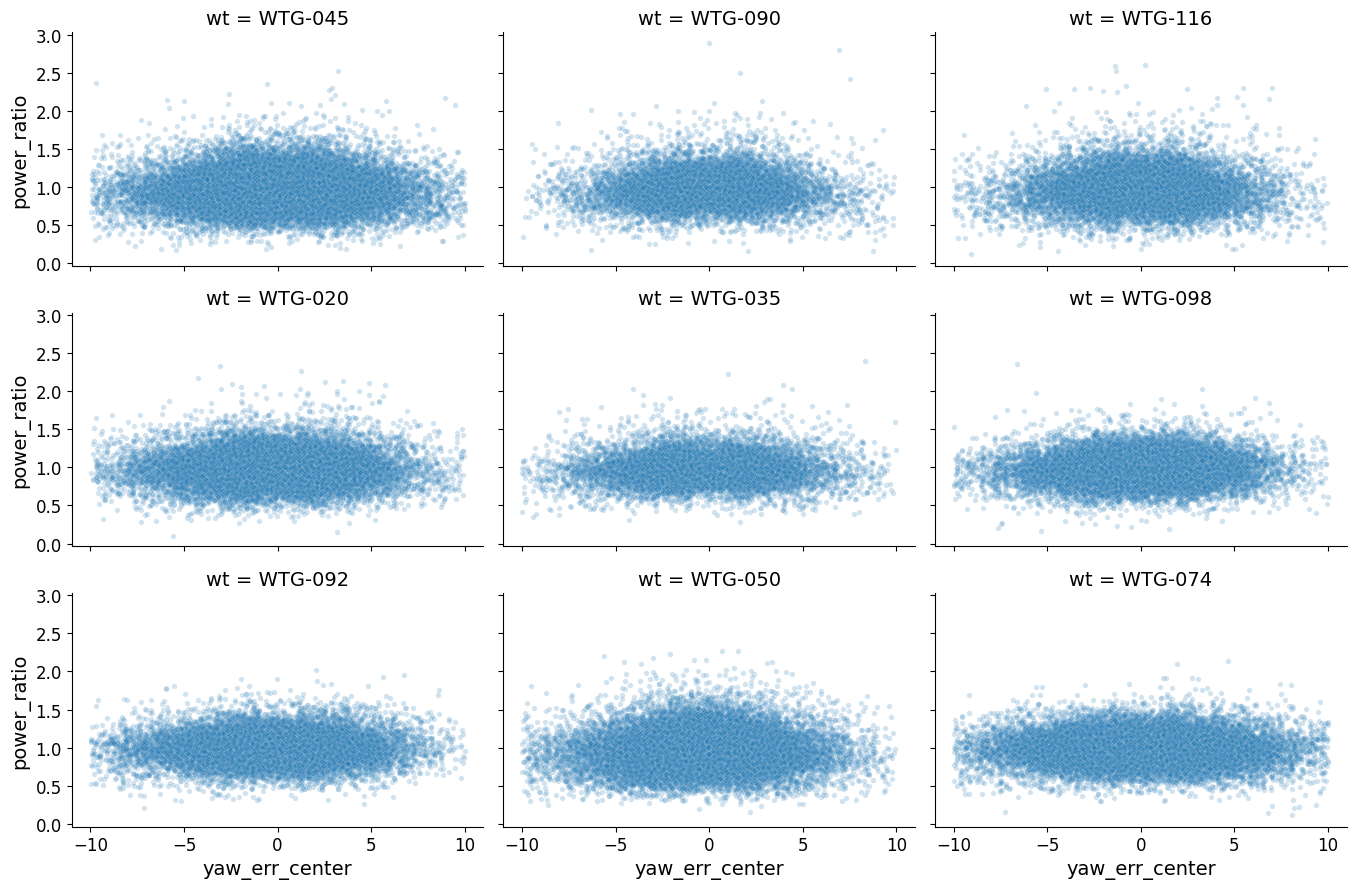

In [3]:
data = (
    ds
    .where(ds['is_analysis'])
    .sel(wt=np.random.choice(
        ds['wt'].data,
        size=9,
        replace=False,
    ))
    .to_dataframe()
    .dropna()
    .reset_index()
)
data

g = sns.relplot(
    kind='scatter',
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    col='wt',
    col_wrap=3,
    height=3,
    aspect=1.5,
    s=15,
    alpha=.2,
)

## Set up the Model

In [4]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(
            self,
            inducing_points: torch.Tensor
        ):

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Fit Model

In [16]:
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



df = (
    ds
    .where(ds['is_analysis'])
    .sel(wt='WTG-075')
    .to_dataframe()
    .dropna()
    .reset_index()
)
df

train_df = resample(
    df,
    replace=False,
    n_samples=5000,
    stratify=df['yaw_err_center']
)
train_df = train_df.reset_index()


x_train = torch.tensor(train_df['yaw_err_center']).to(torch.float32)
scaler = StandardScaler()
# y_train = scaler.fit_transform(train_df[['power_ratio']]).ravel()
# y_train = torch.tensor(y_train).to(torch.float32)
y_train = torch.tensor(train_df['power_ratio']).to(torch.float32)

In [17]:
n_ind = 150
points = (
    torch.tensor(
        np.percentile(
            x_train.numpy(),
            np.linspace(0, 1, n_ind)
        )
    ).to(torch.float32)
)
model = ApproximateGPModel(points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


n_epochs: int = 250

# Find optimal hyperparameters
model.train()
likelihood.train()

# Use Adam
optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

# Objective function
# obj = gpytorch.mlls.VariationalELBO(
obj = gpytorch.mlls.PredictiveLogLikelihood(
    likelihood,
    model,
    num_data=y_train.numel()
)

for n in range(n_epochs):
    # Set 0-gradient
    optimizer.zero_grad()

    # Get the output
    pred = model(x_train)

    # Loss and backward
    loss = -obj(pred, y_train)
    loss.backward()
    optimizer.step()

    # Logger
    if (n + 1) % 5 == 0:
        logger.info(f'Iter {n + 1} of {n_epochs} - Loss: {loss.item()}')

08:24:21 INFO: Iter 5 of 250 - Loss: 1.135157823562622
08:24:22 INFO: Iter 10 of 250 - Loss: 0.7561953663825989
08:24:23 INFO: Iter 15 of 250 - Loss: 0.5433372855186462
08:24:23 INFO: Iter 20 of 250 - Loss: 0.2863781154155731
08:24:23 INFO: Iter 25 of 250 - Loss: 0.0002580932341516018
08:24:23 INFO: Iter 30 of 250 - Loss: -0.2555158734321594
08:24:23 INFO: Iter 35 of 250 - Loss: -0.45675840973854065
08:24:23 INFO: Iter 40 of 250 - Loss: -0.56951904296875
08:24:23 INFO: Iter 45 of 250 - Loss: -0.5890719294548035
08:24:23 INFO: Iter 50 of 250 - Loss: -0.5929890275001526
08:24:24 INFO: Iter 55 of 250 - Loss: -0.5936708450317383
08:24:24 INFO: Iter 60 of 250 - Loss: -0.5934879779815674
08:24:24 INFO: Iter 65 of 250 - Loss: -0.5945612192153931
08:24:24 INFO: Iter 70 of 250 - Loss: -0.5949767827987671
08:24:24 INFO: Iter 75 of 250 - Loss: -0.5955758094787598
08:24:24 INFO: Iter 80 of 250 - Loss: -0.5958978533744812
08:24:24 INFO: Iter 85 of 250 - Loss: -0.5961291790008545
08:24:24 INFO: Iter

## Posterior predictive

In [18]:
model.eval()
likelihood.eval()

x_test = np.linspace(-7.5, 7.5, 201)
x_test = torch.tensor(x_test).to(torch.float32)
with torch.no_grad():

    f_dist = model(x_test)
    mean = f_dist.mean
    # mean = scaler.inverse_transform(f_dist.mean.numpy()[:, None])
    samples = f_dist.sample(torch.Size([25]))
    f_lower, f_upper = f_dist.confidence_region()
    y_dist = likelihood(f_dist)
    y_lower, y_upper = y_dist.confidence_region()

[Text(0.5, 0, '$\\Delta \\gamma\\; [deg]$'),
 (0.9, 1.1),
 Text(0, 0.5, '$P / P_{aligned}\\; [-]$')]

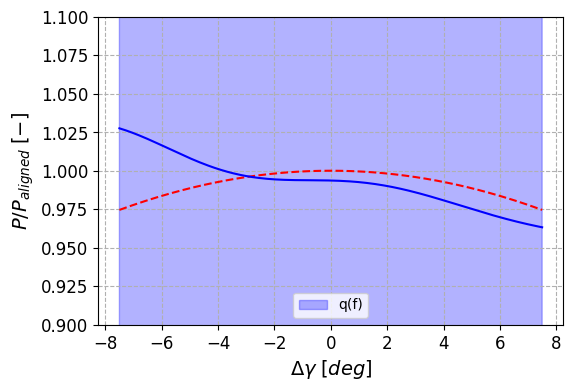

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
line, = ax.plot(x_test, mean, "blue")
ax.fill_between(x_test, f_lower, f_upper, color=line.get_color(), alpha=0.3, label="q(f)")
# ax.fill_between(x_test, y_lower, y_upper, color=line.get_color(), alpha=0.1, label="p(y)")
# ax.scatter(x_test, x_test, c='k', marker='.', label="Data")
ax.legend(loc="best")
ax.set(
    xlabel=r'$\Delta \gamma\; [deg]$',
    ylim=(.9, 1.1),
    ylabel=r'$P / P_{aligned}\; [-]$',
)

C:\Users\pcja001\AppData\Local\Temp\ipykernel_24272\3301830056.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


[Text(0.5, 0, '$\\Delta \\gamma\\; [deg]$'),
 Text(0, 0.5, '$P / P_{aligned}\\; [-]$')]

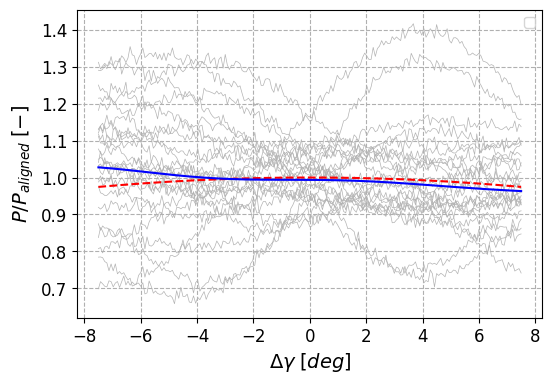

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.plot(x_test, samples.T, lw=.5, c='.7')
ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
line, = ax.plot(x_test, mean, "blue")

ax.legend(loc="best")
ax.set(
    xlabel=r'$\Delta \gamma\; [deg]$',
    # ylim=(.9, 1.1),
    ylabel=r'$P / P_{aligned}\; [-]$',
)

In [21]:
from scipy import optimize

def fun(x) -> float:
    """Function to minimize"""
    with torch.no_grad():
        y = (
            model(torch.tensor([x]).to(torch.float32))
            .mean
            .numpy()
            .item()
        )

    return 1 - y


optimize.minimize_scalar(fun)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.03128409385681152
       x: -8.800000183841846
     nit: 19
    nfev: 26